## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test) 
- [Part III - Regression](#regression)
- [Part IV - Reference List](#Reference_list)
_________________________________________________________________

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, the results of an A/B test run by an e-commerce website will be analyzed. The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

__________

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
prop_conv = df['converted'].sum() # prop_conv : proportion of users converted
prop_conv 

35237

#### As can be seen above, the total number of converted users is 35237, whereas the total number of unique users is 294478.That is, there are values of "0" for some users (people who did not pay for the product), which would not be accounted for in the total.

In [6]:
# to get the proportion, we need to divide by the total number of users:

percentage = (prop_conv / 294478 )*100 # multiply by 100 to convert it to  percentage.
round(percentage, 2)

11.97

The above value is approximately 12%.

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
# dn is a sub-set of the dataframe, df, only containing two important columns for this process
# which are "group" and "treatment". 
dn = df.loc[:,['group', 'landing_page']]
dn

,group,landing_page
0,control,old_page
1,control,old_page
2,treatment,new_page
3,treatment,new_page
4,control,old_page
...,...,...
294473,control,old_page
294474,control,old_page
294475,control,old_page
294476,control,old_page


In [8]:
d1 = dn.loc[(dn['group'] == 'treatment') & (dn['landing_page'] ==  'old_page'), :].count()
d1 #just a variable to store the result of loc function result

group           1965
landing_page    1965
dtype: int64

In [9]:
d2 = dn.loc[(dn['group']== 'control') & (dn['landing_page'] ==  'new_page'), :].count()
d2 #just a variable to store the result of loc function result

group           1928
landing_page    1928
dtype: int64

In [10]:
#The number of times the new page and treatment don't match is
#when treatment matches with the old page and new_page matches with the control.

d1 + d2

group           3893
landing_page    3893
dtype: int64

f. Do any of the rows have missing values?

In [11]:
#To double-check if there are any missing values in the data frame, we need to use info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


There are no missing values. Also, the data types are correct for each column.

___________________________________________________________________

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [12]:
messy_data = df[(df['group']=='treatment') & (df['landing_page']=='old_page') | 
        (df['group']=='control') & (df['landing_page']=='new_page')].index

In [13]:
df2 = df.drop(messy_data)

In [14]:
df2

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [15]:
# Double check that all of the correct rows were removed; this should be 0.
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [16]:
df2.info() # Double check that there is no any problems with the dataframe until now.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [17]:
df2['user_id'].nunique()
df2

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


b. There is one **user_id** repeated in **df2**.  What is it?

In [18]:
df2.user_id.duplicated().sum() # to confirm that there is only one repeated user ID in df2.

1

In [19]:
repeated_id = df2[df2.duplicated(['user_id'])]
repeated_id

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


#### The repeated user id is (773192). 

c. What is the row information for the repeat **user_id**? 

In [20]:
repeated_id

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


#### 1: This user is in the treatment group, so the new page on the company's website should be shown to them.

#### 2: This user ID has not purchased a product from the company.


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [21]:
df2.drop(2893, inplace=True)

In [22]:
df2.user_id.duplicated().sum() # to check that the duplicated row was dropped (removed).

0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [23]:
p_conv = df2.converted.sum()/len(df2) 
# p_conv is the probability (the overall "converted" success rate in the population)
# of an individual converting regardless of the page they receive.

round(p_conv, 4)

0.1196

b. Given that an individual was in the `control` group, what is the probability they converted?

In [24]:
ccr =  df2.query('group == "control"')['converted'].mean() # ccr means control converted rate
ccr

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [25]:
tcr = df2.query('group == "treatment"')['converted'].mean() # tcr tcr means treatment converted rate.
tcr

0.11880806551510564

In [26]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.

obs_diff = tcr - ccr
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [27]:
# We need to count the number of landing to the new page, then dividing it
# by the total users in order to obtain the probability of an individual linking to the new page.

p_new_page = df2.query('landing_page == "new_page"')['landing_page'].count() /df2['user_id'].count()
round(p_new_page, 4)

0.5001

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

#### At this point in the analysis, there is not sufficient evidence to say that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

For this A/B testing, the null and alternative hypotheses are as follows:


**$H_0$** : **$p_{new}$** =< **$p_{old}$**

**$H_1$** : **$p_{new}$** > **$p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>
Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>
Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>
Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

#### Based on the assumption made above, "assume under the null hypothesis", $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page".

In [28]:
rate_new = df2.converted.sum()/len(df2)  
round(rate_new,4)

0.1196

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [29]:
rate_old = df2.converted.sum()/len(df2) 
round(rate_old,4)

0.1196

c. What is $n_{new}$?

In [30]:
df2.groupby('group').count()

,user_id,timestamp,landing_page,converted
group,,,,
control,145274,145274,145274,145274
treatment,145310,145310,145310,145310


#### The number of individuals in the treatment group is 145310.

d. What is $n_{old}$?

In [31]:
df2.groupby('group').count()


,user_id,timestamp,landing_page,converted
group,,,,
control,145274,145274,145274,145274
treatment,145310,145310,145310,145310


#### The the number of individuals in the control group is 145274.

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [32]:
arr = [1,0] #since the column "converted" in df2 has only values of 1 and 0

new_page_converted = np.random.choice(arr, size = 145310 , replace = True).mean()
new_page_converted

0.4994288073773312

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [33]:
old_page_converted = np.random.choice(arr, size = 145274, replace = True).mean()
old_page_converted

0.4995319189944519

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [34]:
p_diffr = new_page_converted.mean() - old_page_converted.mean()
p_diffr

-0.00010311161712067696

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [35]:
# Based on the given feedback from the reviewer, the following simulation is used instead of the previous one.

n_old = df2.query('group =="control"').user_id.count()       # number of individuals who were shown the old_page.
n_new = df2.query('group == "treatment"').user_id.count()    # number of individuals who received new_page.
rate_new = df2.converted.sum()/len(df2)                      # the convert rate for p_new under the null.
rate_old = df2.converted.sum()/len(df2)                      # the convert rate for p_old under the null.

p_diffs = []
new_converted_simulation = np.random.binomial(n_new, rate_new, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, rate_old, 10000)/n_old 
p_diffs = new_converted_simulation - old_converted_simulation

In [36]:
p_diffs = np.array(p_diffs) # to store the result from part "h" in a numpy array.

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

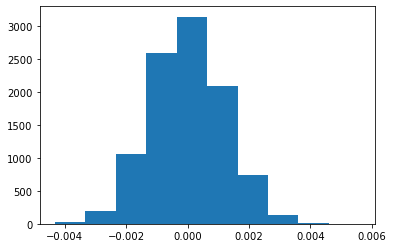

In [37]:
# plot distribution
plt.hist(p_diffs);  # Just for duoble checking for the normal distrbution. 

#### As shown above, I expected the normal distribution.

In [38]:
# distribution under the null hypothesis.
null = np.random.normal(0, p_diffs.std(), p_diffs.size) 

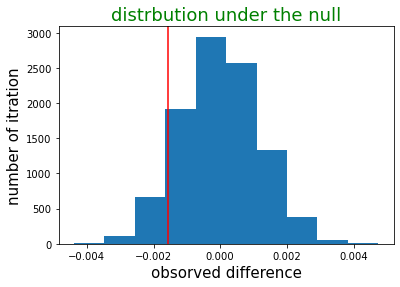

In [39]:
# Plot the distribution under the null hypothesis.

plt.hist(null);
plt.title('distrbution under the null', size = 18, c='green');
plt.xlabel('obsorved difference', size = 15);
plt.ylabel('number of itration', size = 15);


# Plotting a line for the observed statistic
plt.axvline(obs_diff, c='red');


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [40]:
# to get p_value under null: 

p_value = (null > obs_diff).mean()*100
print('The proportion that is greater than the actual difference observed in df2 is', p_value,'%')


The proportion that is greater than the actual difference observed in df2 is 91.24 %


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

### - Answer:

In part "j," the proportion (probability) of values that are bigger than the observed difference is calculated. This is called the observed statistic.
We got a p-value of about 90%, which is higher than the 5% type-I error that is allowed.Therefore, we cannot
reject the null hypothesis. So, the old page is the same as or better than the new page.
Based on this statistical analysis, the company shouldn't launch the new page. Instead, it should keep using the page it already has.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [41]:
import statsmodels.api as sm

In [42]:
# number of conversions between the old page and the new page:

convert_new = df2.loc[(df2['group'] == 'treatment') & (df2['converted'] == 1)].user_id.count()
convert_old = df2.loc[(df2['group'] == 'control') & (df2['converted'] == 1)].user_id.count()
convert_new, convert_old

(17264, 17489)

In [43]:
# number of individuals who were shown the old page and the new page:

n_old = df2.query('group =="control"').user_id.count()
n_new = df2.query('group == "treatment"').user_id.count()
n_old, n_new

(145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [44]:
z_score, p_valuee = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

print(z_score, round(p_valuee*100, 2),'%')


-1.3109241984234394 90.51 %


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

#### The p-value obtained from part "m" is similar to the one computed earlier in part "j." Hence, the p-value in part "m" is also higher than 0.05. Therefore, the null would be accepted. So, the old page is better than the new page.

#### ـــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

### Answer: 
#### For this dataframe, which consists of raw values of either 0 or 1, the best approach to be applied here is the logistic regression approach. Logistic regression is suitable for situational analysis when we have two values. For example, a logistic regression approach can be used to predict whether a credit card transaction is fraudulent or not.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [45]:
df2['intercept'] = 1 # creating the intercept column

df2['ab_page'] = pd.get_dummies(df2['group'])['treatment'] #  creating a column named ab_page
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [46]:
logistic_modle = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logistic_modle.fit() # fitting the logistic model


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [47]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 28 Dec 2022   Pseudo R-squ.:               8.077e-06
Time:                        06:02:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

## - Answer:

The p-value associated with ab_page is 0.190 (19%).

The null and alternative hypotheses that are associated with the regression model are given by the following:

                 
**$H_0$** : **$p_{new}$** =  **$p_{old}$**

**$H_1$** : **$p_{new}$** ≠ **$p_{old}$**

Whereas, the null and alternative hypotheses in part II are:


**$H_0$** : **$p_{new}$** =< **$p_{old}$**

**$H_1$** : **$p_{new}$** > **$p_{old}$**

* In the regression model, p-values are given for testing if the parameter for intercept or slope is equal to zero.
* The p-values generated by this method can tell us whether a specific variable is useful for predicting the response.
* Since the p-value obtained above, 0.190 (19%), is higher than 0.05 (5%), then this p-value is not statistically significant.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

### - Answer

Considering other things to add to the regression model is important. That is, certain factors may cause the user to reconsider whether or not to convert. For example, the user may find the old page comfortable to browse while in a treatment group. Another factor that could influence the user to convert or not is the number of options presented on the page, which could lead to some confusion. There are many other factors that could influence the conversion rate. However, adding more variables to the regression model would, I believe, negatively affect the accuracy and precision of the model. As a result, this will result in a comprehensive analysis. Then it became much more difficult to explain to the client (the company that required the analysis results) what were the important results. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [48]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [49]:
df_new[['UK', 'US', 'CA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [50]:
### Fitting the logistic Model And obtain the Results

logit_country = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page','US', 'CA']])

results_country = logit_country.fit()

results_country.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 28 Dec 2022   Pseudo R-squ.:               2.323e-05
Time:                        06:02:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0506      0.028      1.784      0.074      -0.005       0.106
CA             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

* As can be seen above, the country factor had no influence on the user's decision to convert or not.
* The p-value for the US is 0.074, which is greater than 0.05 (Type I error rate). On the other hand, the p-value for CA is 0.129, which again greater than 0.05.
* Based on this, I can conclude that I fail to reject the null hypotheses in this model too. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [51]:
df_new['ab_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_CA'] = df_new['ab_page'] * df_new['CA']

In [52]:
logit_mod_factors = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','UK','CA','ab_UK', 'ab_CA']])

results_factors = logit_mod_factors.fit()

results_factors.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 28 Dec 2022   Pseudo R-squ.:               3.482e-05
Time:                        06:02:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
UK            -0.0118      0.040     -0.296      0.767      -0.090       0.066
CA             0.0057      0.019      0.306      0.760      -0.031       0.043
ab_UK         -0.0783      0.057     -1.378      0.168      -0.190       0.033
ab_CA         -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

### - Answer: 

* Looking at the factors (countries) of UK, CA, ab_UK, and ab_CA, their p-values are all higher than 0.05. This means that the interaction between the country and the page does not play a significant role. In other words, this attraction, regardless of the country of the user, cannot help increase the conversion rate.


* Therefore, there is not much evidence from which we can say that the new page has a higher conversion rate. This means that for our analysis, we cannot reject the null hypotheses.


* Based on this, I believe that the company should keep the old page until a newer version is released with new features that help increase the conversion rate.

<a id='conclusions'></a>
## Conclusions



At this point in the analysis, I can conclude the following main points and results:

1- The actual difference (obs_diff) between the conversion rates for the two groups was found to be about -0.001578238985355556

2- In order to conduct an A/B test, we had to make the following hypotheses: 
 
                
**$H_0$** : **$p_{new}$** =< **$p_{old}$**

 **$H_1$** : **$p_{new}$** > **$p_{old}$**
 
3- The actual difference was then used to compare it to the null hypotheses. 

4- It appeared that the p-value after this simulation was around 90%. 

5- Almost the same value was obtained using "stats.proportions_ztest" to compute the p-value and z-score.

6- After all, the p-value in both methods was around 90%, which is clearly more than 5%. Therefore, we are unable to reject the null hypotheses.

7- Logistic regression was used to get a statistical summary of what we could say with regard to the p-values. It has been found that the p-value of "ab_page" is around 19%, which indicates that this is not statistically significant.

8- Another important finding from this study is that increasing the number of countries had no effect on the conversion rate. It makes no difference, for example, where the user is located; the conversion rate will not be influenced.


* Based on the above statistics, I can recommend to the company not to change the old page and keep using it until the conversion rate for the newer version is increased.

 - The following are some of the limitations and difficulties of this analysis using the A/B testing approach:  
 
 1- When current consumers see a change for the first time, the novelty effect and change aversion occur.
 
 2- consistency between test subjects in the experiment and control groups.
 
 3- What a conversion rate means in practise (the cost of launching a new feature vs. the gain from the increase in conversion)

##### ــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــــ

<a id='Reference_list'></a>
## Reference List


1- https://www.youtube.com/watch?v=bBmfEUshmzQ 

2- https://www.youtube.com/watch?v=_2nS53nYrzQ 

3- https://www.statology.org/pandas-drop-rows-based-on-multiple-conditions/  

4- https://www.statology.org/pandas-find-duplicates/ 

5- https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html  

6- https://sparkbyexamples.com/python/how-to-use-numpy-random-choice-in-python/  

7- https://viewf35b56fb.udacity-student-workspaces.com/notebooks/average_classroom_time_solutions.ipynb  

8- https://kanoki.org/2020/01/21/pandas-dataframe-filter-with-multiple-conditions/ 

9- https://learn.udacity.com/nanodegrees/nd002-mcit/parts/cd0005/lessons/ls12054/concepts/1d713d40-8a42-4197-bf11-2d82d989b741 

10- https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html 

11- https://learn.udacity.com/nanodegrees/nd002-mcit/parts/cd0005/lessons/ls12052/concepts/bf0b42bb-fa77-45bc-a9d3-a84c6bbd82a7


12- https://learn.udacity.com/nanodegrees/nd002-mcit/parts/cd0005/lessons/ls12054/concepts/2bae5c2b-48b0-4439-b459-f3bc5cae9dd1 

13- https://learn.udacity.com/nanodegrees/nd002-mcit/parts/cd0005/lessons/ls11579/concepts/131b0cac-2507-49f0-8e31-75543d35018b  


